In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
import torch
from dotenv import load_dotenv
import io
from google.cloud import storage
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig
import pandas as pd
import numpy as np
from IPython.display import display, Markdown
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd

### This package will be included in our repo, but it is only a prompt template

In [3]:
from golemai.nlp.prompts import QUERY_INTRO_NO_ANS, SYSTEM_MSG_RAG, SYSTEM_MSG_RAG_SHORT
from golemai.nlp.llm_module import prepare_prompt
from golemai.nlp.llm_resp_gen import LLMRespGen

In [4]:
load_dotenv(), torch.cuda.is_available()

(True, True)

In [5]:
DATA_DIR = 'data'
SCRIPTS_DIR = 'scripts'
ATT_DIR = 'attentions'
GEMMA_DIR = 'gemma2_new_dataset'

TRAIN_SAMPLE_FILE = 'all_examples_with_idx.parquet'
TEST_SAMPLE_FILE = 'test_research_sample.parquet'

QUESTION_COL = 'query'
CONTEXT_COL = 'context'
ANSWER_COL = 'answer'

# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
MODEL_ID = "unsloth/gemma-2-9b-it-bnb-4bit"

In [7]:
att_path = os.path.join('..', SCRIPTS_DIR, GEMMA_DIR, ATT_DIR)
dataset_path = os.path.join("..", DATA_DIR, TRAIN_SAMPLE_FILE)

In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, token=os.environ["HF_TOKEN"])

### Loading the dataset

In [9]:
def agg_att(x: np.ndarray, f1_agg: str = 'mean', f2_agg: str = 'mean'):

    agg_funcs = {
        'mean': lambda x: np.mean(x, axis=-1),
        'max': lambda x: np.max(x, axis=-1),
        'min': lambda x: np.min(x, axis=-1),
        'median': lambda x: np.median(x, axis=-1),
    }

    return agg_funcs[f1_agg](agg_funcs[f2_agg](x))

In [10]:
def prep_att_pipe(
    att_path: str,
    n_first_tokens: int = None,
    skip_first_n_tokens: int = None,
    n_context_tokens_start_idx: int = None,
    n_context_tokens_end_idx: int = None,
    window_size: int = 0,
    window_step: int = 4,
    postprocess_fn: callable = None,
    **kwargs: dict,
) -> np.ndarray:
    """
    Function to prepare the attention tensor for further analysis.
    It removes the prompt tokens and the last offset_size tokens from the context.
    """

    att_tensor = np.load(att_path)
    print('Initial shape:', att_tensor.shape)

    skip_first_n_tokens = skip_first_n_tokens if skip_first_n_tokens is not None else 0
    n_first_tokens = n_first_tokens if n_first_tokens is not None else att_tensor.shape[-2]

    att_tensor = att_tensor[..., slice(skip_first_n_tokens, n_first_tokens + skip_first_n_tokens), slice(n_context_tokens_start_idx, n_context_tokens_end_idx)]
    print('After slicing:', att_tensor.shape)

    if (window_size) and (att_tensor.shape[-2] > window_size):

        att_tensor = {
            tuple([i, i + window_size]) : postprocess_fn(att_tensor[..., i: i + window_size, :], **kwargs) if kwargs else postprocess_fn(att_tensor[..., i: i + window_size, :])
            for i in range(0, att_tensor.shape[-2], window_step) if i + window_size <= att_tensor.shape[-2]
        }

    else:
        att_tensor = postprocess_fn(att_tensor, **kwargs) if kwargs else postprocess_fn(att_tensor)

    # print('Final shape:', att_tensor.shape)

    return att_tensor

In [11]:
def find_indices(response, spans) -> list:
    """
    Function to find the starting and ending indices of each substring in 'problematic_spans' within 'model_response'.
    Returns a list of tuples (start, end) for each problematic span.
    If a span cannot be found, it returns (None, None).
    """

    indices = []
    if isinstance(spans, str):
        spans = [spans]

    if spans is None:
        return None
    
    for span in spans:
        start = response.rfind(span)
        if start != -1:
            end = start + len(span)
            indices.append((start, end))
        else:
            indices.append((None, None))
    
    return indices

In [12]:
df = pd.read_parquet(dataset_path)

In [13]:
df['contain_hallu'].value_counts(normalize=True)

False    0.858887
True     0.141113
Name: contain_hallu, dtype: float64

### Now I will find `start` and `end` indicies for `context` and `query`. Need to use tokenizer to find exact positions.

In [14]:
CONTEXT_SPAN = '`CONTEXT`:'
QUERY_SPAN = '`QUERY`:'
ANSWER_SPAN = '`ANSWER`:<end_of_turn>'

In [15]:
context_starts, context_ends = [], []
query_starts, query_ends = [], []

for i, row in df.iterrows():

    att_file = f"{i}.npy"
    print(f"att_file: {att_file}")

    context_text = row['formatted_context']
    context_text_end_idx = context_text.find('`ANSWER`:<end_of_turn>')

    prompt_text = context_text[:context_text_end_idx]

    context_start = find_indices(prompt_text, CONTEXT_SPAN)[0][1]
    context_end = find_indices(prompt_text, QUERY_SPAN)[0][0]

    query_start = find_indices(prompt_text, QUERY_SPAN)[0][1]
    query_end = len(prompt_text)

    inputs = tokenizer(context_text, return_tensors="pt", padding=True, return_offsets_mapping=True, add_special_tokens=False)
    offset_mappings = inputs['offset_mapping'][0].tolist()

    context_token_start_idx, context_token_end_idx = None, None
    query_token_start_idx, query_token_end_idx = None, None

    for idx, (start, end) in enumerate(offset_mappings):

        if (start <= context_start <= end):
            context_token_start_idx = idx

        if (start <= context_end <= end) and (context_token_end_idx is None):
            context_token_end_idx = idx

        if (start <= query_start <= end):
            query_token_start_idx = idx
        
        if (start <= query_end <= end) and (query_token_end_idx is None):
            query_token_end_idx = idx

    context_starts.append(context_token_start_idx)
    context_ends.append(context_token_end_idx)
    query_starts.append(query_token_start_idx)
    query_ends.append(query_token_end_idx)

att_file: bioask_1000.npy
att_file: bioask_1001.npy
att_file: bioask_1009.npy
att_file: bioask_101.npy
att_file: bioask_1021.npy
att_file: bioask_1022.npy
att_file: bioask_1024.npy
att_file: bioask_1033.npy
att_file: bioask_1045.npy
att_file: bioask_1053.npy
att_file: bioask_1058.npy
att_file: bioask_1060.npy
att_file: bioask_1063.npy
att_file: bioask_1080.npy
att_file: bioask_1081.npy
att_file: bioask_1087.npy
att_file: bioask_1091.npy
att_file: bioask_1104.npy
att_file: bioask_1117.npy
att_file: bioask_1119.npy
att_file: bioask_1120.npy
att_file: bioask_1127.npy
att_file: bioask_1131.npy
att_file: bioask_1136.npy
att_file: bioask_114.npy
att_file: bioask_1142.npy
att_file: bioask_1143.npy
att_file: bioask_1147.npy
att_file: bioask_1154.npy
att_file: bioask_1155.npy
att_file: bioask_1162.npy
att_file: bioask_1176.npy
att_file: bioask_1184.npy
att_file: bioask_1195.npy
att_file: bioask_1197.npy
att_file: bioask_1203.npy
att_file: bioask_121.npy
att_file: bioask_1214.npy
att_file: bioas

In [16]:
df['context_start_idx'], df['context_end_idx'] = context_starts, context_ends
df['query_start_idx'], df['query_end_idx'] = query_starts, query_ends

In [17]:
df

dataset                                              query  \
bioask_1000        bioask  Czy możliwe jest oczyszczenie pseudopodiów do ...   
bioask_1001        bioask  Jaki jest mechanizm działania deaminazy cytydy...   
bioask_1009        bioask  Ile selenoprotein jest zakodowanych w ludzkim ...   
bioask_101         bioask  Która z ludzkich selenoprotein zawiera kilka r...   
bioask_1021        bioask  Jak leczy się chorobę Riedela (zapalenie tarcz...   
...                   ...                                                ...   
poquad_v2_9744  poquad_v2  Co było przyczyną zniesienia święta Trzeciego ...   
poquad_v2_9909  poquad_v2          Dlaczego zamknięto pub Edwardsa w Dudley?   
poquad_v2_9939  poquad_v2  Jaki piłkarz uległ wypadkowi podczas Ligii Mis...   
poquad_v2_9967  poquad_v2      W którym roku prawdopodobnie wymyślono "grę"?   
poquad_v2_9997  poquad_v2              Czy Franek Dolas trafił do więzienia?   

                                                           answer  \
bioask_1000     Pseudopodia mogą być oczyszczane przy użyciu r...   
bioask_1001     Podczas odwrotnej transkrypcji APOBEC3G deamin...   
bioask_1009     25. 15kDa, DI1, DI2, DI3, GPx1, GPx2, GPx3, GP...   
bioask_101      Selenoproteina P, która zawiera 10 selenocystein.   
bioask_1021     Zapalenie tarczycy typu Riedela jest rzadkim s...   
...                                                           ...   
poquad_v2_9744                     krwawe demonstracje studenckie   
poquad_v2_9909                                    z powodu pożaru   
poquad_v2_9939  Nie mogę udzielić odpowiedzi na to pytanie na ...   
poquad_v2_9967                                               1977   
poquad_v2_9997                                                tak   

                                                          context  \
bioask_1000     `Dokument [1]:` Migracja komórek wymaga wypukł...   
bioask_1001     `Dokument [1]:` Rodzina deaminaz deoksycytydyn...   
bioask_1009     `Dokument [1]:` TŁO: Białka zawierające seleno...   
bioask_101      `Dokument [1]:` Selenoproteina P (Sepp1) jest ...   
bioask_1021     `Dokument [1]:` Wstęp: Inwazyjne włókniste zap...   
...                                                           ...   
poquad_v2_9744  `Dokument [ "Święto Narodowe Trzeciego Maja" ]...   
poquad_v2_9909  `Dokument [ "Duncan Edwards" ]:` Edwards uważa...   
poquad_v2_9939  `Dokument [ "Chelsea F.C." ]:` Głównym celem M...   
poquad_v2_9967  `Dokument [ "Gra (gra umysłowa)" ]:` Geneza „G...   
poquad_v2_9997  `Dokument [ "Jak rozpętałem drugą wojnę świato...   

                context_length  \
bioask_1000               1547   
bioask_1001               2445   
bioask_1009               1296   
bioask_101                2282   
bioask_1021               2457   
...                        ...   
poquad_v2_9744             347   
poquad_v2_9909             368   
poquad_v2_9939             507   
poquad_v2_9967             327   
poquad_v2_9997             477   

                                                   model_response  decision  \
bioask_1000     Tak, tekst mówi o metodzie oczyszczania pseudo...      True   
bioask_1001     APOBEC3G hamuje replikację wirusa HIV-1 poprze...      True   
bioask_1009                                                    25      True   
bioask_101      Ludzka selenoproteina P (HSelP) zawiera 10 res...      True   
bioask_1021     Leczenie kortykosteroidami w zapaleniu tarczyc...      True   
...                                                           ...       ...   
poquad_v2_9744     Krwawych demonstracji studenckich w 1946 roku.      True   
poquad_v2_9909  W 2001 jego imieniem nazwano jeden z pubów zna...      True   
poquad_v2_9939  Nie mogę udzielić odpowiedzi na to pytanie na ...      True   
poquad_v2_9967                                               1977      True   
poquad_v2_9997             Tak, Franek Dolas trafił do więzienia.      True   

               problematic_spans  \
bioas

In [18]:
def process_row(
    row, 
    idx,
    n_first_tokens: int = None,
    skip_first_n_tokens: int = None,
    postprocess_fn: callable = None,
    window_size: int = 0):

    att_file = f"{idx}.npy"
    print(f"att_file: {att_file}")

    n_context_tokens_start_idx = row.get('context_start_idx', None)
    n_context_tokens_end_idx = row.get('context_end_idx', None)

    att_file_path = os.path.join(att_path, att_file)

    try:

        att_tensor = prep_att_pipe(
            att_path=att_file_path,
            n_first_tokens=n_first_tokens,
            skip_first_n_tokens=skip_first_n_tokens,
            n_context_tokens_start_idx=n_context_tokens_start_idx,
            n_context_tokens_end_idx=n_context_tokens_end_idx,
            postprocess_fn=postprocess_fn,
            window_size=window_size
        )
        
        return att_tensor, None, att_file
    
    except Exception as e:
        print(f"Error: {e}")
        return None, att_file, att_file


In [19]:
df_old = pd.read_parquet(os.path.join("..", DATA_DIR, 'research_sample_with_indices.parquet'))

In [20]:
df = df.loc[~df.index.isin(df_old['id'].values)]

In [21]:
df

dataset                                              query  \
bioask_1000        bioask  Czy możliwe jest oczyszczenie pseudopodiów do ...   
bioask_1001        bioask  Jaki jest mechanizm działania deaminazy cytydy...   
bioask_1009        bioask  Ile selenoprotein jest zakodowanych w ludzkim ...   
bioask_101         bioask  Która z ludzkich selenoprotein zawiera kilka r...   
bioask_1021        bioask  Jak leczy się chorobę Riedela (zapalenie tarcz...   
...                   ...                                                ...   
poquad_v2_9744  poquad_v2  Co było przyczyną zniesienia święta Trzeciego ...   
poquad_v2_9909  poquad_v2          Dlaczego zamknięto pub Edwardsa w Dudley?   
poquad_v2_9939  poquad_v2  Jaki piłkarz uległ wypadkowi podczas Ligii Mis...   
poquad_v2_9967  poquad_v2      W którym roku prawdopodobnie wymyślono "grę"?   
poquad_v2_9997  poquad_v2              Czy Franek Dolas trafił do więzienia?   

                                                           answer  \
bioask_1000     Pseudopodia mogą być oczyszczane przy użyciu r...   
bioask_1001     Podczas odwrotnej transkrypcji APOBEC3G deamin...   
bioask_1009     25. 15kDa, DI1, DI2, DI3, GPx1, GPx2, GPx3, GP...   
bioask_101      Selenoproteina P, która zawiera 10 selenocystein.   
bioask_1021     Zapalenie tarczycy typu Riedela jest rzadkim s...   
...                                                           ...   
poquad_v2_9744                     krwawe demonstracje studenckie   
poquad_v2_9909                                    z powodu pożaru   
poquad_v2_9939  Nie mogę udzielić odpowiedzi na to pytanie na ...   
poquad_v2_9967                                               1977   
poquad_v2_9997                                                tak   

                                                          context  \
bioask_1000     `Dokument [1]:` Migracja komórek wymaga wypukł...   
bioask_1001     `Dokument [1]:` Rodzina deaminaz deoksycytydyn...   
bioask_1009     `Dokument [1]:` TŁO: Białka zawierające seleno...   
bioask_101      `Dokument [1]:` Selenoproteina P (Sepp1) jest ...   
bioask_1021     `Dokument [1]:` Wstęp: Inwazyjne włókniste zap...   
...                                                           ...   
poquad_v2_9744  `Dokument [ "Święto Narodowe Trzeciego Maja" ]...   
poquad_v2_9909  `Dokument [ "Duncan Edwards" ]:` Edwards uważa...   
poquad_v2_9939  `Dokument [ "Chelsea F.C." ]:` Głównym celem M...   
poquad_v2_9967  `Dokument [ "Gra (gra umysłowa)" ]:` Geneza „G...   
poquad_v2_9997  `Dokument [ "Jak rozpętałem drugą wojnę świato...   

                context_length  \
bioask_1000               1547   
bioask_1001               2445   
bioask_1009               1296   
bioask_101                2282   
bioask_1021               2457   
...                        ...   
poquad_v2_9744             347   
poquad_v2_9909             368   
poquad_v2_9939             507   
poquad_v2_9967             327   
poquad_v2_9997             477   

                                                   model_response  decision  \
bioask_1000     Tak, tekst mówi o metodzie oczyszczania pseudo...      True   
bioask_1001     APOBEC3G hamuje replikację wirusa HIV-1 poprze...      True   
bioask_1009                                                    25      True   
bioask_101      Ludzka selenoproteina P (HSelP) zawiera 10 res...      True   
bioask_1021     Leczenie kortykosteroidami w zapaleniu tarczyc...      True   
...                                                           ...       ...   
poquad_v2_9744     Krwawych demonstracji studenckich w 1946 roku.      True   
poquad_v2_9909  W 2001 jego imieniem nazwano jeden z pubów zna...      True   
poquad_v2_9939  Nie mogę udzielić odpowiedzi na to pytanie na ...      True   
poquad_v2_9967                                               1977      True   
poquad_v2_9997             Tak, Franek Dolas trafił do więzienia.      True   

               problematic_spans  \
bioas

In [22]:
OFFSET_SIZE = 8
FIRST_N_TOKENS = 8

In [23]:
X, errors = {}, []

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(process_row, row, idx, None, OFFSET_SIZE, agg_att, 8) for idx, row in df.iterrows()]
    
    for future in as_completed(futures):

        result, error, att_file = future.result()
        
        if error:
            errors.append(error)
        else:
            X[att_file] = result

print(f"Completed with {len(errors)} errors.")

att_file: bioask_1000.npyatt_file: bioask_1009.npyatt_file: bioask_1001.npy
att_file: bioask_1091.npyatt_file: bioask_1022.npy
att_file: bioask_1021.npyatt_file: bioask_1033.npyatt_file: bioask_101.npy
att_file: bioask_1127.npyatt_file: bioask_1131.npyatt_file: bioask_1045.npyatt_file: bioask_1053.npyatt_file: bioask_1087.npyatt_file: bioask_1058.npy
att_file: bioask_1063.npyatt_file: bioask_1104.npyatt_file: bioask_1081.npy




att_file: bioask_1136.npy





att_file: bioask_1154.npy

att_file: bioask_1176.npyatt_file: bioask_1184.npyatt_file: bioask_1142.npyatt_file: bioask_1143.npyatt_file: bioask_1162.npyatt_file: bioask_1155.npy
att_file: bioask_1195.npyatt_file: bioask_114.npyatt_file: bioask_1237.npy
att_file: bioask_1203.npyatt_file: bioask_1197.npy





att_file: bioask_121.npy

att_file: bioask_1214.npyatt_file: bioask_1260.npy





att_file: bioask_1264.npy
att_file: bioask_1266.npy
att_file: bioask_1275.npyatt_file: bioask_1285.npy

att_file: bioask_1291.npy
att_file: bioas

In [27]:
Y = {}

for i, row in df.iterrows():

    att_file = f"{i}.npy"

    if att_file not in X:
        continue

    print(f"att_file: {att_file}")

    n_prompt_tokens = row['prompt_length']
    hallu_tokens = row['hallu_tokens']

    if isinstance(X.get(att_file), dict):

        y = {
            k: hallu_tokens[n_prompt_tokens + k[0]: n_prompt_tokens + k[1]].any().astype(int)
            for k in X[att_file].keys()
        }

    else:

        y = hallu_tokens[n_prompt_tokens: n_prompt_tokens + FIRST_N_TOKENS].any().astype(int)

        # if len(y) < FIRST_N_TOKENS:
        #     print(f"Padding {len(y)} tokens for {att_file}")
        #     y = np.concatenate([y, np.zeros(FIRST_N_TOKENS - len(y))])

    print(f"Success: {att_file}\n\n")

    Y[att_file] = y
    

att_file: bioask_1000.npy
Success: bioask_1000.npy


att_file: bioask_1001.npy
Success: bioask_1001.npy


att_file: bioask_1009.npy
Success: bioask_1009.npy


att_file: bioask_101.npy
Success: bioask_101.npy


att_file: bioask_1021.npy
Success: bioask_1021.npy


att_file: bioask_1022.npy
Success: bioask_1022.npy


att_file: bioask_1033.npy
Success: bioask_1033.npy


att_file: bioask_1045.npy
Success: bioask_1045.npy


att_file: bioask_1053.npy
Success: bioask_1053.npy


att_file: bioask_1058.npy
Success: bioask_1058.npy


att_file: bioask_1063.npy
Success: bioask_1063.npy


att_file: bioask_1081.npy
Success: bioask_1081.npy


att_file: bioask_1087.npy
Success: bioask_1087.npy


att_file: bioask_1091.npy
Success: bioask_1091.npy


att_file: bioask_1104.npy
Success: bioask_1104.npy


att_file: bioask_1119.npy
Success: bioask_1119.npy


att_file: bioask_1120.npy
Success: bioask_1120.npy


att_file: bioask_1127.npy
Success: bioask_1127.npy


att_file: bioask_1131.npy
Success: bioask_1131.n

In [24]:
X.keys()

dict_keys(['bioask_1127.npy', 'bioask_1009.npy', 'bioask_1022.npy', 'bioask_1033.npy', 'bioask_1154.npy', 'bioask_1000.npy', 'bioask_1162.npy', 'bioask_1293.npy', 'bioask_1197.npy', 'bioask_1053.npy', 'bioask_1176.npy', 'bioask_121.npy', 'bioask_1203.npy', 'bioask_1091.npy', 'bioask_1058.npy', 'bioask_1063.npy', 'bioask_1266.npy', 'bioask_1214.npy', 'bioask_101.npy', 'bioask_1328.npy', 'bioask_1291.npy', 'bioask_1275.npy', 'bioask_1104.npy', 'bioask_1120.npy', 'bioask_1298.npy', 'bioask_1264.npy', 'bioask_1155.npy', 'bioask_1081.npy', 'bioask_1087.npy', 'bioask_1237.npy', 'bioask_1143.npy', 'bioask_1285.npy', 'bioask_1352.npy', 'bioask_1446.npy', 'bioask_1464.npy', 'bioask_1317.npy', 'bioask_1404.npy', 'bioask_1554.npy', 'bioask_1379.npy', 'bioask_1400.npy', 'bioask_1444.npy', 'bioask_1325.npy', 'bioask_1260.npy', 'bioask_1355.npy', 'bioask_1573.npy', 'bioask_1300.npy', 'bioask_1045.npy', 'bioask_1472.npy', 'bioask_1478.npy', 'bioask_1630.npy', 'bioask_1450.npy', 'bioask_1131.npy', 'bi

In [29]:
X_context = {}
Y_context = {}

for key, value in X.items():

    if isinstance(value, dict):

        for k in value.keys():
            X_context[f"{key}__{k}"] = value[k]
            Y_context[f"{key}__{k}"] = Y[key][k]
        
    else:
        X_context[key] = value
        Y_context[key] = Y[key]

In [30]:
dataset_names = [s.split('__')[0].removesuffix('.npy').rsplit('_', 1)[0] for s in sorted(X_context.keys())]

In [35]:
X_context = np.array([
    X_context[att_file]
    for att_file in sorted(X_context.keys())
])

In [36]:
Y_context = np.array([
    Y_context[att_file]
    for att_file in sorted(Y_context.keys())
])

In [37]:
len(X_context), len(Y_context), len(dataset_names)

(21280, 21280, 21280)

In [38]:
del X, Y

### Attension on context analysis

In [39]:
X_context.shape, len(Y_context)

((21280, 42, 16), 21280)

In [40]:
FEATURE_NAMES = [
    f"layer_{i}_head_{j}" for i in range(X_context.shape[1]) for j in range(X_context.shape[2])
]

In [41]:
context_df = pd.DataFrame(X_context.reshape(X_context.shape[0], -1), columns=FEATURE_NAMES)

In [42]:
context_df

layer_0_head_0  layer_0_head_1  layer_0_head_2  layer_0_head_3  \
0            0.000644        0.000553        0.000075        0.000284   
1            0.000585        0.000570        0.000037        0.000126   
2            0.000655        0.000469        0.000071        0.000206   
3            0.000637        0.000503        0.000035        0.000127   
4            0.000445        0.000392        0.000030        0.000124   
...               ...             ...             ...             ...   
21275        0.002058        0.001493        0.000218        0.000493   
21276        0.002350        0.002285        0.000107        0.000884   
21277        0.001825        0.001627        0.000098        0.000320   
21278        0.001835        0.001616        0.000126        0.000401   
21279        0.001817        0.001689        0.000080        0.000310   

       layer_0_head_4  layer_0_head_5  layer_0_head_6  layer_0_head_7  \
0            0.000480        0.000598        0.000236        0.000246   
1            0.000386        0.000532        0.000197        0.000220   
2            0.000516        0.000600        0.000234        0.000259   
3            0.000448        0.000560        0.000228        0.000247   
4            0.000367        0.000391        0.000121        0.000178   
...               ...             ...             ...             ...   
21275        0.000921        0.001601        0.000554        0.000654   
21276        0.001136        0.000744        0.000513        0.000421   
21277        0.001262        0.001341        0.000744        0.000973   
21278        0.001377        0.001364        0.000855        0.001033   
21279        0.000980        0.000950        0.000584        0.000748   

       layer_0_head_8  layer_0_head_9  ...  layer_41_head_6  layer_41_head_7  \
0            0.000581        0.000652  ...         0.000008         0.000019   
1            0.000583        0.000608  ...         0.000009         0.000020   
2            0.000600        0.000644  ...         0.000010         0.000027   
3            0.000594        0.000620  ...         0.000010         0.000034   
4            0.000398        0.000448  ...         0.000009         0.000014   
...               ...             ...  ...              ...              ...   
21275        0.001650        0.002087  ...         0.000016         0.000057   
21276        0.002138        0.002771  ...         0.000058         0.000043   
21277        0.001641        0.002460  ...         0.000025         0.000086   
21278        0.001669        0.002295  ...         0.000025         0.000078   
21279        0.001360        0.001698  ...         0.000031         0.000045   

       layer_41_head_8  layer_41_head_9  layer_41_head_10  layer_41_head_11  \
0             0.000008         0.000007          0.000045          0.000180   
1             0.000009         0.000006          0.000054          0.000169   
2             0.000008         0.000007          0.000060          0.000162   
3             0.000008         0.000006          0.000079          0.000194   
4             0.000010         0.000008          0.000066          0.000109   
...                ...              ...               ...               ...   
21275         0.000034         0.000030          0.000115          0.000309   
21276         0.000103         0.000110          0.000318          0.000441   
21277         0.000033         0.000017          0.000393          0.000557   
21278         0.000032         0.000014          0.000272          0.000425   
21279         0.000032         0.000033          0.000133          0.000315   

       layer_41_head_12  layer_41_head_13  layer_41_head_14  layer_41_head_15  
0              0.000023          0.000007          0.000011          0.000017  
1              0.000024          0.000005          0.000013          0.000013  
2              0.000028          0.000007          0.000008          0.000011  
3              0.000032

In [43]:
context_df['label'] = Y_context.tolist()
context_df['dataset'] = dataset_names

In [44]:
context_df.to_parquet(os.path.join("..", DATA_DIR, 'all_sample_context_features_mean_agg_windowed.parquet'))

In [45]:
context_df.head(2)

layer_0_head_0  layer_0_head_1  layer_0_head_2  layer_0_head_3  \
0        0.000644        0.000553        0.000075        0.000284   
1        0.000585        0.000570        0.000037        0.000126   

   layer_0_head_4  layer_0_head_5  layer_0_head_6  layer_0_head_7  \
0        0.000480        0.000598        0.000236        0.000246   
1        0.000386        0.000532        0.000197        0.000220   

   layer_0_head_8  layer_0_head_9  ...  layer_41_head_8  layer_41_head_9  \
0        0.000581        0.000652  ...         0.000008         0.000007   
1        0.000583        0.000608  ...         0.000009         0.000006   

   layer_41_head_10  layer_41_head_11  layer_41_head_12  layer_41_head_13  \
0          0.000045          0.000180          0.000023          0.000007   
1          0.000054          0.000169          0.000024          0.000005   

   layer_41_head_14  layer_41_head_15  label  dataset  
0          0.000011          0.000017      0   bioask  
1          0.000013          0.000013      0   bioask  

[2 rows x 674 columns]

In [104]:
query_df = pd.DataFrame(X_context.reshape(X_context.shape[0], -1), columns=FEATURE_NAMES)
query_df['label'] = Y_context
query_df['dataset'] = df['dataset']

In [105]:
query_df.to_parquet(os.path.join("..", DATA_DIR, 'query_features_mean_agg.parquet'))

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, Markdown
from collections import Counter
import random
from lightgbm import LGBMClassifier

In [2]:
DATA_DIR = 'data'

In [3]:
context_df = pd.read_parquet(os.path.join("..", DATA_DIR, 'all_sample_context_features_mean_agg_windowed.parquet'))

In [4]:
context_df['dataset'].value_counts()

nq             7437
poquad_v2      5468
hotpotqa_en    2669
bioask         2146
hotpotqa_pl    1921
polqa          1639
Name: dataset, dtype: int64

In [5]:
context_df['label'].value_counts()

0    19148
1     2132
Name: label, dtype: int64

### What is the difference between attension for hallucinated and correct answers

In [6]:
stats_grouped = context_df.drop(columns=['dataset']).groupby('label').agg(['median']).T
stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]
stats_grouped

label                           0         1  median_proportion
layer_0_head_0   median  0.000715  0.000692           1.034126
layer_0_head_1   median  0.000638  0.000621           1.027650
layer_0_head_2   median  0.000030  0.000047           0.630189
layer_0_head_3   median  0.000227  0.000236           0.963618
layer_0_head_4   median  0.000557  0.000514           1.083488
...                           ...       ...                ...
layer_41_head_11 median  0.000143  0.000128           1.123832
layer_41_head_12 median  0.000081  0.000054           1.506682
layer_41_head_13 median  0.000013  0.000010           1.341317
layer_41_head_14 median  0.000020  0.000017           1.196491
layer_41_head_15 median  0.000025  0.000022           1.120000

[672 rows x 3 columns]

### Differences in median

In [7]:
stats_grouped.sort_values('median_proportion', ascending=False).head(10)

label                           0         1  median_proportion
layer_30_head_9  median  0.000474  0.000093           5.114038
layer_14_head_13 median  0.000304  0.000068           4.483516
layer_25_head_13 median  0.000480  0.000134           3.582926
layer_15_head_11 median  0.000122  0.000034           3.568696
layer_28_head_6  median  0.000446  0.000126           3.546490
layer_31_head_15 median  0.000587  0.000166           3.541502
layer_15_head_3  median  0.000522  0.000148           3.520900
layer_11_head_9  median  0.000176  0.000051           3.425581
layer_21_head_5  median  0.000408  0.000126           3.238636
layer_12_head_15 median  0.000405  0.000131           3.100867

In [8]:
stats_grouped.sort_values('median_proportion', ascending=True).head(10)

label                           0         1  median_proportion
layer_10_head_6  median  0.000129  0.000220           0.588874
layer_0_head_2   median  0.000030  0.000047           0.630189
layer_9_head_5   median  0.000036  0.000047           0.761665
layer_4_head_4   median  0.000138  0.000181           0.761873
layer_23_head_5  median  0.000047  0.000061           0.770204
layer_11_head_10 median  0.000031  0.000040           0.776276
layer_33_head_11 median  0.000014  0.000017           0.820513
layer_28_head_0  median  0.000008  0.000010           0.825581
layer_17_head_11 median  0.000098  0.000117           0.839959
layer_33_head_8  median  0.000015  0.000018           0.846667

In [9]:
stats_grouped_sorted = stats_grouped.sort_values('median_proportion', ascending=False).reset_index()
stats_grouped_sorted

label           level_0 level_1         0         1  median_proportion
0       layer_30_head_9  median  0.000474  0.000093           5.114038
1      layer_14_head_13  median  0.000304  0.000068           4.483516
2      layer_25_head_13  median  0.000480  0.000134           3.582926
3      layer_15_head_11  median  0.000122  0.000034           3.568696
4       layer_28_head_6  median  0.000446  0.000126           3.546490
..                  ...     ...       ...       ...                ...
667     layer_23_head_5  median  0.000047  0.000061           0.770204
668      layer_4_head_4  median  0.000138  0.000181           0.761873
669      layer_9_head_5  median  0.000036  0.000047           0.761665
670      layer_0_head_2  median  0.000030  0.000047           0.630189
671     layer_10_head_6  median  0.000129  0.000220           0.588874

[672 rows x 5 columns]

In [10]:
TOP_N = 10

top_7_props = stats_grouped_sorted.head(TOP_N)['level_0'].to_list()
lowest_7_props = stats_grouped_sorted.tail(TOP_N)['level_0'].to_list()

for_eda = context_df[top_7_props + lowest_7_props + ['label', 'dataset']]

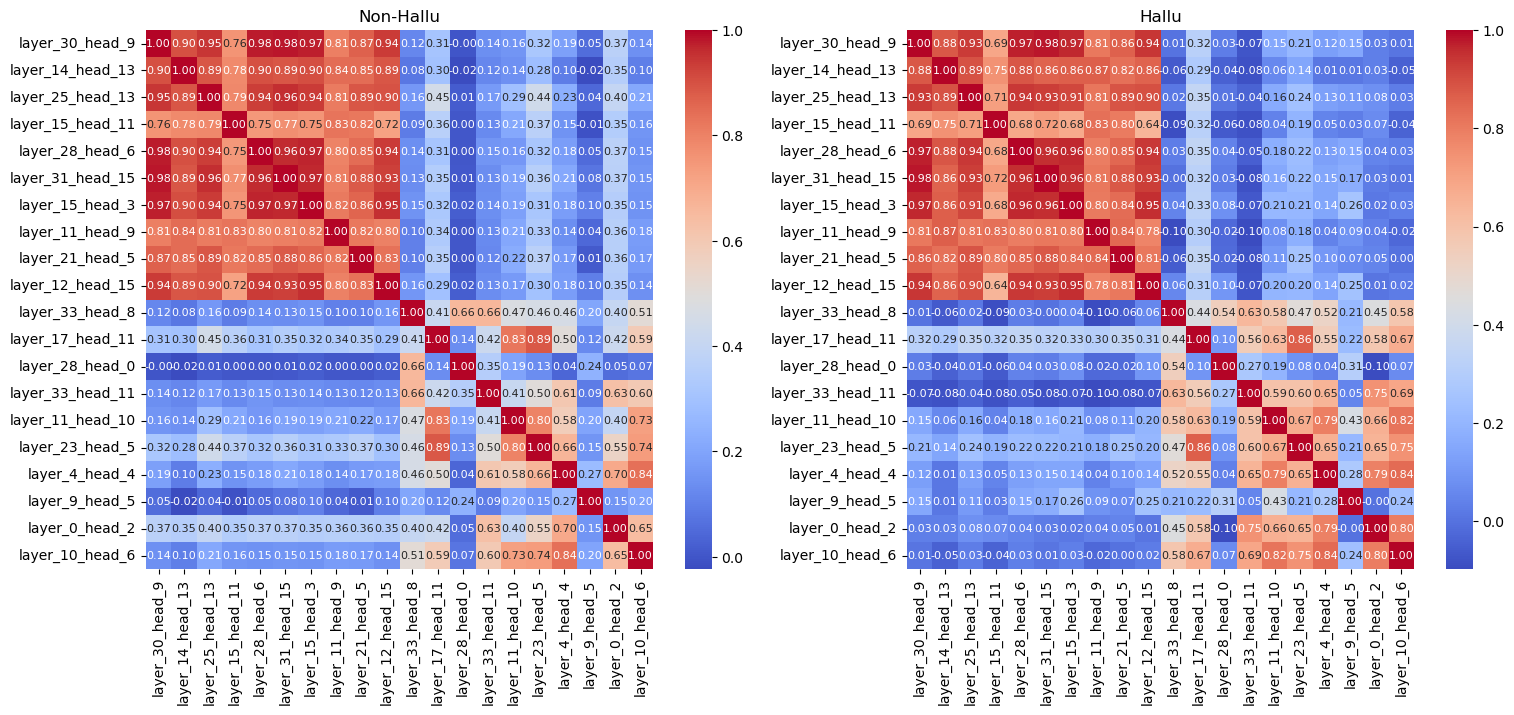

In [11]:
corr_non_hallu = for_eda.loc[for_eda['label'] == 0].drop(columns=['dataset', 'label']).corr()
corr_hallu = for_eda.loc[for_eda['label'] == 1].drop(columns=['dataset', 'label']).corr()
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

for i, (corr, title) in enumerate(zip([corr_non_hallu, corr_hallu], ['Non-Hallu', 'Hallu'])):
    mask = corr.abs() < 0.0
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, ax=ax[i], annot_kws={"size": 8})
    ax[i].set_title(title)

plt.grid(False)
plt.show()

### `Spearman` correletion (looks for monotonic correletions, more robust, no need for liner dependence)

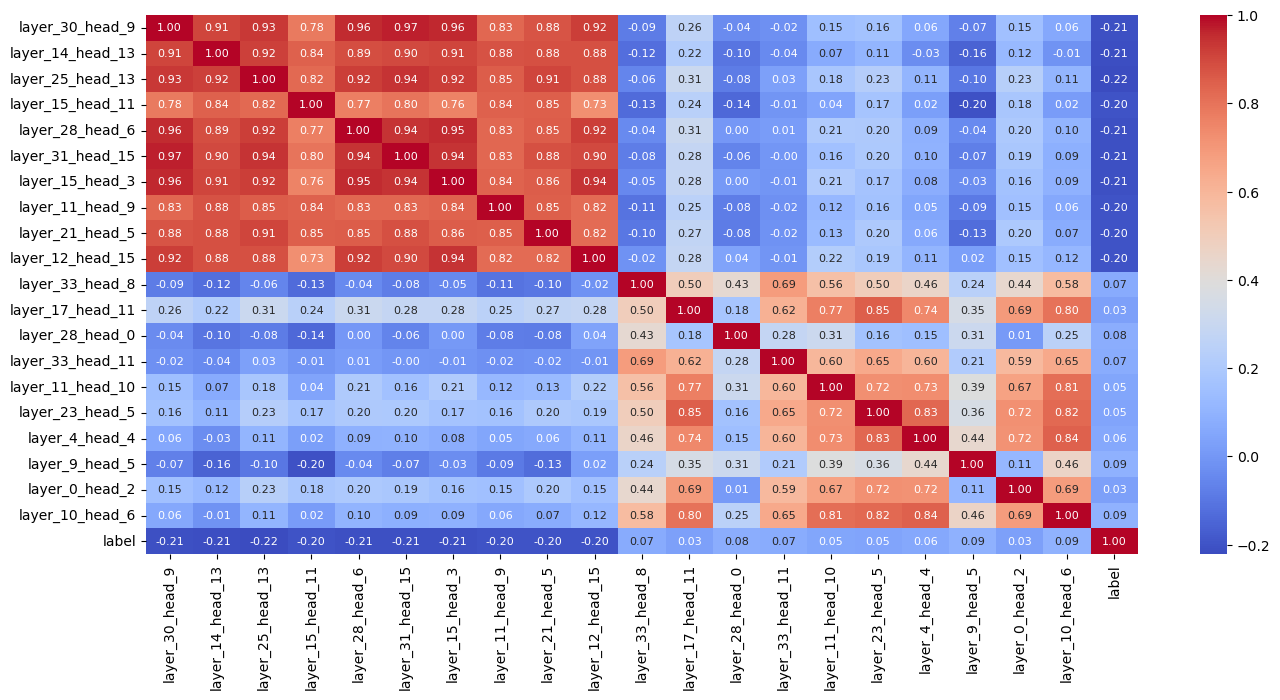

In [12]:
corr_all = for_eda.drop(columns=['dataset']).corr(method='spearman')
fig, ax = plt.subplots(1, 1, figsize=(16, 7))
sns.heatmap(corr_all, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 8}, ax=ax)
plt.grid(False)
plt.show()

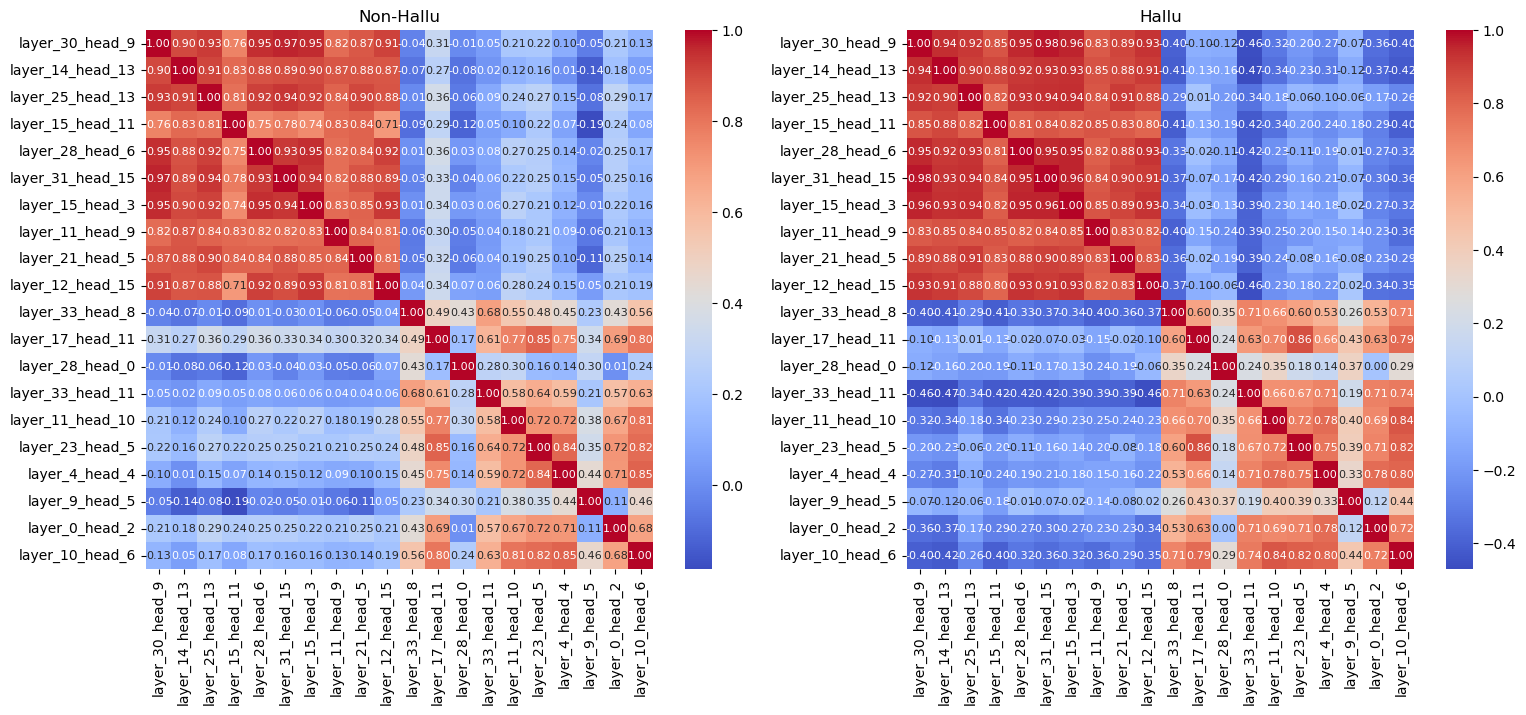

In [13]:
corr_non_hallu = for_eda.loc[for_eda['label'] == 0].drop(columns=['dataset', 'label']).corr(method='spearman')
corr_hallu = for_eda.loc[for_eda['label'] == 1].drop(columns=['dataset', 'label']).corr(method='spearman')
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

for i, (corr, title) in enumerate(zip([corr_non_hallu, corr_hallu], ['Non-Hallu', 'Hallu'])):
    mask = corr.abs() < 0.0
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, ax=ax[i], annot_kws={"size": 8})
    ax[i].set_title(title)

plt.grid(False)
plt.show()

### Before plotting the distributions, I will check also stats for grouped datasets

In [14]:
grouped_df = context_df.groupby(['dataset', 'label']).agg(['median']).T
grouped_df

dataset                    bioask           hotpotqa_en           hotpotqa_pl  \
label                           0         1           0         1           0   
layer_0_head_0   median  0.000634  0.000578    0.000614  0.000670    0.001153   
layer_0_head_1   median  0.000553  0.000501    0.000528  0.000583    0.000995   
layer_0_head_2   median  0.000041  0.000049    0.000011  0.000018    0.000058   
layer_0_head_3   median  0.000174  0.000181    0.000182  0.000199    0.000303   
layer_0_head_4   median  0.000506  0.000474    0.000455  0.000469    0.000803   
...                           ...       ...         ...       ...         ...   
layer_41_head_11 median  0.000153  0.000126    0.000097  0.000101    0.000258   
layer_41_head_12 median  0.000043  0.000039    0.000051  0.000035    0.000092   
layer_41_head_13 median  0.000011  0.000009    0.000008  0.000007    0.000020   
layer_41_head_14 median  0.000013  0.000013    0.000019  0.000016    0.000032   
layer_41_head_15 median  0.000019  0.000017    0.000020  0.000020    0.000036   

dataset                                  nq               polqa            \
label                           1         0         1         0         1   
layer_0_head_0   median  0.001104  0.000594  0.000602  0.000987  0.001018   
layer_0_head_1   median  0.000962  0.000537  0.000538  0.000885  0.000929   
layer_0_head_2   median  0.000078  0.000011  0.000016  0.000058  0.000076   
layer_0_head_3   median  0.000323  0.000193  0.000203  0.000264  0.000302   
layer_0_head_4   median  0.000737  0.000476  0.000460  0.000736  0.000726   
...                           ...       ...       ...       ...       ...   
layer_41_head_11 median  0.000240  0.000094  0.000097  0.000223  0.000208   
layer_41_head_12 median  0.000067  0.000067  0.000043  0.000068  0.000050   
layer_41_head_13 median  0.000016  0.000008  0.000007  0.000017  0.000014   
layer_41_head_14 median  0.000022  0.000017  0.000014  0.000023  0.000017   
layer_41_head_15 median  0.000033  0.000018  0.000018  0.000031  0.000028   

dataset                 poquad_v2            
label                           0         1  
layer_0_head_0   median  0.002062  0.001991  
layer_0_head_1   median  0.001787  0.001673  
layer_0_head_2   median  0.000124  0.000111  
layer_0_head_3   median  0.000480  0.000476  
layer_0_head_4   median  0.001645  0.001369  
...                           ...       ...  
layer_41_head_11 median  0.000482  0.000457  
layer_41_head_12 median  0.000164  0.000145  
layer_41_head_13 median  0.000036  0.000034  
layer_41_head_14 median  0.000035  0.000041  
layer_41_head_15 median  0.000060  0.000061  

[672 rows x 12 columns]

In [15]:
dataset_counts = context_df.groupby(['dataset', 'label']).size().to_frame().reset_index().rename(columns={0: 'count'})
dataset_counts

dataset  label  count
0        bioask      0   2035
1        bioask      1    111
2   hotpotqa_en      0   2382
3   hotpotqa_en      1    287
4   hotpotqa_pl      0   1668
5   hotpotqa_pl      1    253
6            nq      0   6588
7            nq      1    849
8         polqa      0   1359
9         polqa      1    280
10    poquad_v2      0   5116
11    poquad_v2      1    352

In [16]:
TOP_N = 10

In [17]:
previous_features = []
highest_non_hallu, highest_hallu = [], []

for dataset in grouped_df.columns.levels[0]:

    stats_grouped = grouped_df[dataset].reset_index()

    stats_grouped = stats_grouped.rename(columns={'level_0': 'feature', 'level_1': 'statistic'})

    stats_grouped['median_diff'] = stats_grouped[0] - stats_grouped[1]
    stats_grouped['median_perc_diff'] = stats_grouped['median_diff'] / stats_grouped[0] * 100
    
    stats_grouped.drop(columns=['median_diff', 'statistic'], inplace=True)

    stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values

    # display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))

    highest_non_hallu_context = stats_grouped.sort_values('median_proportion', ascending=False).head(TOP_N)
    highest_hallu_context = stats_grouped.sort_values('median_proportion', ascending=True).head(TOP_N)

    previous_features.extend(highest_non_hallu_context['feature'].values)
    previous_features.extend(highest_hallu_context['feature'].values)

    highest_hallu.append(highest_hallu_context)
    highest_non_hallu.append(highest_non_hallu_context)

In [18]:
feature_counts = Counter(previous_features)
common_features = {feature for feature, count in feature_counts.items() if count > 1}

# Generate a random color for each common feature
def generate_random_color():
    return f'#{random.randint(0, 0xFFFFFF):06x}'

# Assign colors from the palette to common features
color_map = {feature: generate_random_color() for feature in common_features}

def highlight_common_features(s):
    return [f'color: {color_map[v]}' if v in color_map else '' for v in s]

In [19]:

display(Markdown(f"## **Highest non-hallu**"))
for df, dataset in zip(highest_non_hallu, grouped_df.columns.levels[0]):

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values
    display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))
    
    styled_df = df.style.apply(highlight_common_features, subset=['feature'])
    display(styled_df)

display(Markdown(f"## **Highest hallu**"))
for df, dataset in zip(highest_hallu, grouped_df.columns.levels[0]):

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values
    display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))

    styled_df = df.style.apply(highlight_common_features, subset=['feature'])
    display(styled_df)



## **Highest non-hallu**

### **bioask**, hallu: 111, non-hallu: 2035

### **hotpotqa_en**, hallu: 287, non-hallu: 2382

### **hotpotqa_pl**, hallu: 253, non-hallu: 1668

### **nq**, hallu: 849, non-hallu: 6588

### **polqa**, hallu: 280, non-hallu: 1359

### **poquad_v2**, hallu: 352, non-hallu: 5116

## **Highest hallu**

### **bioask**, hallu: 111, non-hallu: 2035

### **hotpotqa_en**, hallu: 287, non-hallu: 2382

### **hotpotqa_pl**, hallu: 253, non-hallu: 1668

### **nq**, hallu: 849, non-hallu: 6588

### **polqa**, hallu: 280, non-hallu: 1359

### **poquad_v2**, hallu: 352, non-hallu: 5116

In [20]:
context_df[list(common_features) + ['label', 'dataset']]

layer_36_head_9  layer_25_head_13  layer_14_head_13  layer_10_head_6  \
0             0.000003          0.000246          0.000148         0.000127   
1             0.000005          0.000509          0.000129         0.000082   
2             0.000002          0.000496          0.000276         0.000111   
3             0.000004          0.000553          0.000239         0.000108   
4             0.000075          0.000321          0.000266         0.000077   
...                ...               ...               ...              ...   
21275         0.000040          0.000152          0.000015         0.000755   
21276         0.000154          0.000952          0.000224         0.000891   
21277         0.000010          0.000845          0.000280         0.000344   
21278         0.000018          0.001019          0.000545         0.000301   
21279         0.000048          0.000604          0.000545         0.000348   

       layer_23_head_5  layer_4_head_4  layer_11_head_9  layer_31_head_7  \
0             0.000068        0.000216         0.000088         0.000214   
1             0.000017        0.000085         0.000231         0.000360   
2             0.000043        0.000126         0.000151         0.000305   
3             0.000021        0.000099         0.000203         0.000316   
4             0.000085        0.000086         0.000147         0.000227   
...                ...             ...              ...              ...   
21275         0.000220        0.000645         0.000010         0.000026   
21276         0.000299        0.001429         0.000394         0.001554   
21277         0.000271        0.000693         0.000229         0.001194   
21278         0.000260        0.000523         0.000735         0.001226   
21279         0.000185        0.000377         0.000630         0.000624   

       layer_5_head_6  layer_28_head_2  ...  layer_33_head_11  layer_0_head_2  \
0            0.000102         0.000362  ...          0.000009        0.000075   
1            0.000041         0.000453  ...          0.000007        0.000037   
2            0.000098         0.000532  ...          0.000006        0.000071   
3            0.000066         0.000443  ...          0.000006        0.000035   
4            0.000025         0.000404  ...          0.000061        0.000030   
...               ...              ...  ...               ...             ...   
21275        0.000491         0.000040  ...          0.000062        0.000218   
21276        0.000735         0.002232  ...          0.000021        0.000107   
21277        0.000473         0.001316  ...          0.000012        0.000098   
21278        0.000649         0.001217  ...          0.000008        0.000126   
21279        0.000537         0.000784  ...          0.000012        0.000080   

       layer_15_head_3  layer_31_head_15  layer_28_head_6  layer_9_head_5  \
0             0.000143          0.000351         0.000162        0.000040   
1             0.000165          0.000532         0.000359        0.000032   
2             0.000356          0.000446         0.000387        0.000025   
3             0.000322          0.000461         0.000441        0.000013   
4             0.000391          0.000361         0.000267        0.000011   
...                ...               ...              ...             ...   
21275         0.000095          0.000024         0.000058        0.000059   
21276         0.002153          0.002378         0.001559        0.000306   
21277         0.000642          0.001154         0.000569        0.000020   
21278         0.000977          0.001325         0.000852        0.000023   
21279         0.000846          0.000737         0.000677        0.000045   

       layer_33_head_8  layer_15_head_2  label    dataset  
0             0.000007         0.000085      0     bioask  
1             0.000007         0.000019      0     bioask  
2             0.000005         0.000118      0     bioask  
3      

In [21]:
plt.style.use('ggplot')

In [22]:
def viz_numeric_data(
    df: pd.DataFrame,
    numerical_columns: list,
    target_column: str,
    group_column: str = None,
    orient: str = 'v',
    fig_cols: int = 2,
    title_func: callable = None,
    show_stripplot: bool = True,
    **kwargs,
):

    sns.set_style("white")
    plt.rcParams['ytick.labelsize'] = 7
    plt.rcParams['ytick.labelcolor'] = '#30333b'

    plt.rcParams['xtick.labelsize'] = 7
    plt.rcParams['xtick.labelcolor'] = '#30333b'

    n_of_cols = len(numerical_columns)
    n_rows = n_of_cols // fig_cols + n_of_cols % fig_cols
    fig, ax = plt.subplots(n_rows, fig_cols, figsize=(12, 4 * n_rows), dpi=120)

    ax = ax.flatten()

    palette = {
        0: '#c9c7c7',
        1: '#4375e8'
    }

    for i, col in enumerate(numerical_columns):

        if col == target_column:
            continue

        sns.violinplot(
            hue=target_column if isinstance(target_column, str) else None, 
            y=col if orient == 'v' else group_column,
            data=df.loc[(df[col].quantile(0.95) > df[col]) & (df[col] > df[col].quantile(0.05))], 
            orient=orient, 
            x=group_column if orient == 'v' else col,
            ax=ax[i],
            palette=palette,
            legend=False
        )

        if show_stripplot:

            sns.stripplot(
                x=group_column if orient == 'v' else col, 
                y=col if orient == 'v' else group_column,
                data=df.loc[(df[col].quantile(0.99) > df[col]) & (df[col] > df[col].quantile(0.01))], 
                orient=orient,
                hue=target_column,
                ax=ax[i],
                palette='dark:black',
                alpha=0.1,  # Transparency for better visibility
                jitter=True,  # Add some jitter to avoid overlap
                dodge=True,
                legend=False
            )

        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        ax[i].set_title(title_func(col), loc='left', fontsize=12, pad=kwargs.get('title_pad', 1))


        if orient == 'v':
            ax[i].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, color='gray', size=3)
        else:
            ax[i].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, color='gray', size=3)
        
        # ax[i].grid(False)
    
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)

        ax[i].spines['bottom'].set_visible(False if orient == 'v' else True)
        ax[i].spines['left'].set_visible(True if orient == 'v' else False)

        ax[i].spines['left'].set_color('gray')
        ax[i].spines['bottom'].set_color('gray')

    for j in range(i + 1, len(ax)):
        fig.delaxes(ax[j])

    fig.tight_layout(h_pad=5, w_pad=3)
    plt.show()

### Whole dataset without grouping

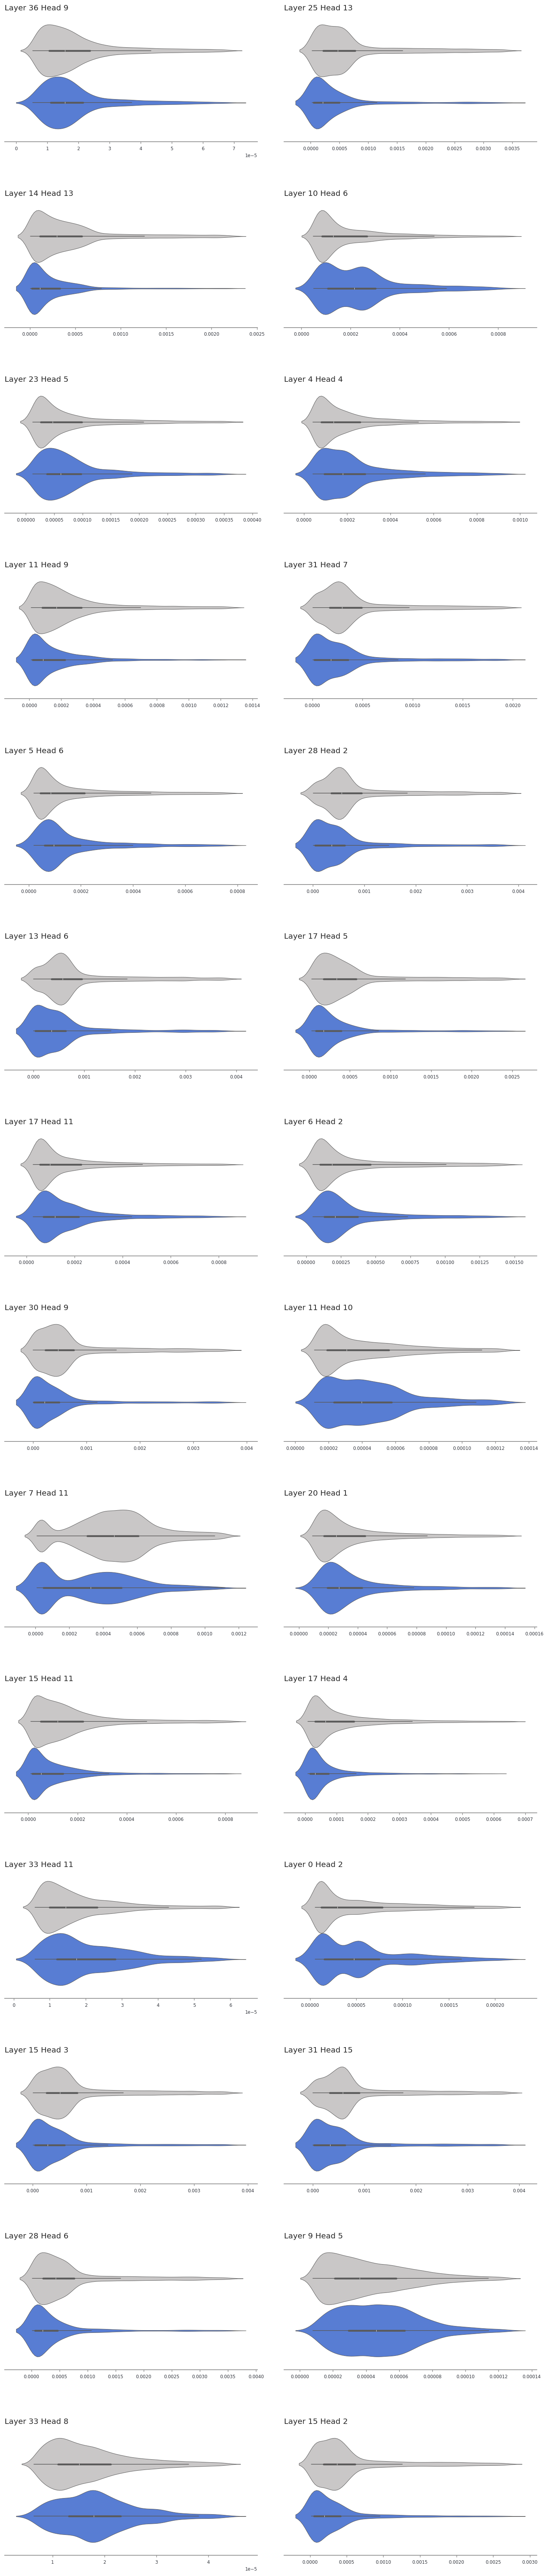

In [23]:
viz_numeric_data(
    context_df[list(common_features) + ['label', 'dataset']],
    list(common_features),
    'label',
    group_column=None,
    fig_cols=2,
    orient='h',
    title_func=lambda x: " ".join(x.split('_')).title(),
    show_stripplot=False
)

### Grouped by dataset

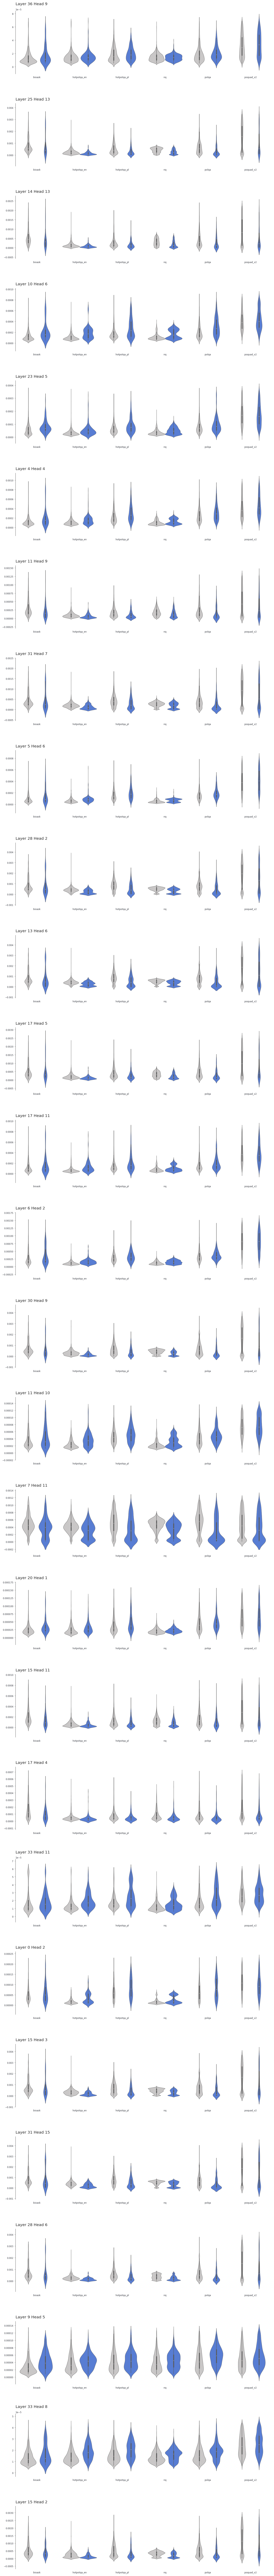

In [24]:
viz_numeric_data(
    context_df[list(common_features) + ['label', 'dataset']],
    list(common_features),
    'label',
    group_column='dataset',
    fig_cols=1,
    orient='v',
    title_func=lambda x: " ".join(x.split('_')).title(),
    title_pad=10,
    show_stripplot=False
)

In [25]:
context_df[list(common_features) + ['label', 'dataset']]

layer_36_head_9  layer_25_head_13  layer_14_head_13  layer_10_head_6  \
0             0.000003          0.000246          0.000148         0.000127   
1             0.000005          0.000509          0.000129         0.000082   
2             0.000002          0.000496          0.000276         0.000111   
3             0.000004          0.000553          0.000239         0.000108   
4             0.000075          0.000321          0.000266         0.000077   
...                ...               ...               ...              ...   
21275         0.000040          0.000152          0.000015         0.000755   
21276         0.000154          0.000952          0.000224         0.000891   
21277         0.000010          0.000845          0.000280         0.000344   
21278         0.000018          0.001019          0.000545         0.000301   
21279         0.000048          0.000604          0.000545         0.000348   

       layer_23_head_5  layer_4_head_4  layer_11_head_9  layer_31_head_7  \
0             0.000068        0.000216         0.000088         0.000214   
1             0.000017        0.000085         0.000231         0.000360   
2             0.000043        0.000126         0.000151         0.000305   
3             0.000021        0.000099         0.000203         0.000316   
4             0.000085        0.000086         0.000147         0.000227   
...                ...             ...              ...              ...   
21275         0.000220        0.000645         0.000010         0.000026   
21276         0.000299        0.001429         0.000394         0.001554   
21277         0.000271        0.000693         0.000229         0.001194   
21278         0.000260        0.000523         0.000735         0.001226   
21279         0.000185        0.000377         0.000630         0.000624   

       layer_5_head_6  layer_28_head_2  ...  layer_33_head_11  layer_0_head_2  \
0            0.000102         0.000362  ...          0.000009        0.000075   
1            0.000041         0.000453  ...          0.000007        0.000037   
2            0.000098         0.000532  ...          0.000006        0.000071   
3            0.000066         0.000443  ...          0.000006        0.000035   
4            0.000025         0.000404  ...          0.000061        0.000030   
...               ...              ...  ...               ...             ...   
21275        0.000491         0.000040  ...          0.000062        0.000218   
21276        0.000735         0.002232  ...          0.000021        0.000107   
21277        0.000473         0.001316  ...          0.000012        0.000098   
21278        0.000649         0.001217  ...          0.000008        0.000126   
21279        0.000537         0.000784  ...          0.000012        0.000080   

       layer_15_head_3  layer_31_head_15  layer_28_head_6  layer_9_head_5  \
0             0.000143          0.000351         0.000162        0.000040   
1             0.000165          0.000532         0.000359        0.000032   
2             0.000356          0.000446         0.000387        0.000025   
3             0.000322          0.000461         0.000441        0.000013   
4             0.000391          0.000361         0.000267        0.000011   
...                ...               ...              ...             ...   
21275         0.000095          0.000024         0.000058        0.000059   
21276         0.002153          0.002378         0.001559        0.000306   
21277         0.000642          0.001154         0.000569        0.000020   
21278         0.000977          0.001325         0.000852        0.000023   
21279         0.000846          0.000737         0.000677        0.000045   

       layer_33_head_8  layer_15_head_2  label    dataset  
0             0.000007         0.000085      0     bioask  
1             0.000007         0.000019      0     bioask  
2             0.000005         0.000118      0     bioask  
3      

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

In [41]:
TOP_N_FEATURES = 7

In [42]:
validation_results = []

# Loop over each unique dataset
for dataset in context_df['dataset'].unique():

    in_dist_sample = context_df.loc[context_df['dataset'] != dataset]
    out_dist_sample = context_df.loc[context_df['dataset'] == dataset]

    stats_grouped = in_dist_sample.drop(columns=['dataset']).groupby('label').agg(['median']).T
    stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]
    stats_grouped = stats_grouped.reset_index().rename(columns={'level_0': 'feature', 'level_1': 'statistic'})

    # print(stats_grouped)

    train_columns = stats_grouped.sort_values('median_proportion', ascending=False).head(TOP_N_FEATURES)['feature'].values.tolist() \
        + stats_grouped.sort_values('median_proportion', ascending=True).head(TOP_N_FEATURES)['feature'].values.tolist()

    # train_columns = list(common_features)

    print(f"Train columns: {train_columns}")

    X_train, X_val = in_dist_sample[train_columns], out_dist_sample[train_columns]
    y_train, y_val = in_dist_sample['label'], out_dist_sample['label']
    
    # scaler = RobustScaler()
    #X_train = scaler.fit_transform(X_train)
    # X_val = scaler.transform(X_val)

    print(f"{X_train.shape = }, {X_val.shape = }")

    models = {
        # 'LogisticRegression': LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42),
        'LGBMClassifier': LGBMClassifier(
            n_estimators=100,
            learning_rate=0.002,
            max_depth=10,
            num_leaves=15,
            class_weight='balanced',
            #reg_alpha=0.1,
            # reg_lambda=0.1,
            random_state=42,
            n_jobs=-1,
            silent=True,
            verbose=-1
        )
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        train_auc = roc_auc_score(y_train, train_pred)
        print(f"Train AUC for {dataset} with {model_name}: {train_auc}")

        # Validate the model
        y_pred = model.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)

        # Store the result
        validation_results.append({
            'dataset': dataset,
            'model': model_name,
            'train_auc': train_auc,
            'val_auc': auc
        })

    print('\n\n')

Train columns: ['layer_30_head_9', 'layer_14_head_13', 'layer_31_head_15', 'layer_15_head_3', 'layer_28_head_6', 'layer_25_head_13', 'layer_15_head_11', 'layer_0_head_2', 'layer_10_head_6', 'layer_23_head_5', 'layer_11_head_10', 'layer_4_head_4', 'layer_9_head_5', 'layer_28_head_0']
X_train.shape = (19134, 14), X_val.shape = (2146, 14)
Train AUC for bioask with LGBMClassifier: 0.6720561608515832



Train columns: ['layer_14_head_13', 'layer_30_head_9', 'layer_28_head_6', 'layer_15_head_11', 'layer_25_head_13', 'layer_11_head_9', 'layer_21_head_5', 'layer_10_head_6', 'layer_9_head_5', 'layer_0_head_2', 'layer_4_head_4', 'layer_28_head_0', 'layer_23_head_5', 'layer_11_head_10']
X_train.shape = (18611, 14), X_val.shape = (2669, 14)
Train AUC for hotpotqa_en with LGBMClassifier: 0.6780564906329011



Train columns: ['layer_30_head_9', 'layer_14_head_13', 'layer_31_head_15', 'layer_28_head_6', 'layer_25_head_13', 'layer_15_head_11', 'layer_15_head_3', 'layer_10_head_6', 'layer_0_head_2', 'l

In [43]:
pd.DataFrame(validation_results)

dataset           model  train_auc   val_auc
0       bioask  LGBMClassifier   0.672056  0.620803
1  hotpotqa_en  LGBMClassifier   0.678056  0.598742
2  hotpotqa_pl  LGBMClassifier   0.697033  0.647796
3           nq  LGBMClassifier   0.688907  0.628347
4        polqa  LGBMClassifier   0.679489  0.681458
5    poquad_v2  LGBMClassifier   0.704975  0.531116

### What is the difference between attension for hallucinated and correct answers (`QUERY`)

In [109]:
stats_grouped = query_df.drop(columns=['dataset']).groupby('label').agg(['median']).T
stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]
stats_grouped

label                           0         1  median_proportion
layer_0_head_0   median  0.002794  0.002856           0.978297
layer_0_head_1   median  0.002306  0.002146           1.074667
layer_0_head_2   median  0.000037  0.000078           0.467098
layer_0_head_3   median  0.002285  0.002702           0.845747
layer_0_head_4   median  0.002306  0.001645           1.401739
...                           ...       ...                ...
layer_41_head_11 median  0.001828  0.001897           0.963801
layer_41_head_12 median  0.000825  0.000825           0.999422
layer_41_head_13 median  0.000178  0.000122           1.463988
layer_41_head_14 median  0.000427  0.000206           2.075876
layer_41_head_15 median  0.000432  0.000375           1.152844

[672 rows x 3 columns]

### Differences in median

In [111]:
stats_grouped.sort_values('median_proportion', ascending=False).head(10)

label                           0         1  median_proportion
layer_13_head_6  median  0.000154  0.000011          14.640227
layer_15_head_3  median  0.001299  0.000094          13.867006
layer_31_head_15 median  0.002007  0.000262           7.654388
layer_15_head_2  median  0.003706  0.000488           7.600978
layer_30_head_9  median  0.003057  0.000405           7.556865
layer_13_head_4  median  0.000790  0.000111           7.119227
layer_12_head_15 median  0.001178  0.000171           6.897033
layer_14_head_13 median  0.010483  0.001720           6.093126
layer_31_head_7  median  0.003195  0.000574           5.567096
layer_15_head_10 median  0.001197  0.000230           5.195343

In [112]:
stats_grouped.sort_values('median_proportion', ascending=True).head(10)

label                           0         1  median_proportion
layer_0_head_2   median  0.000037  0.000078           0.467098
layer_10_head_3  median  0.007542  0.015438           0.488510
layer_21_head_4  median  0.007820  0.013348           0.585882
layer_18_head_5  median  0.008629  0.013565           0.636108
layer_38_head_8  median  0.000326  0.000513           0.636279
layer_35_head_10 median  0.000104  0.000159           0.653688
layer_8_head_10  median  0.011787  0.017868           0.659693
layer_23_head_5  median  0.006622  0.009640           0.686981
layer_19_head_0  median  0.010239  0.014889           0.687676
layer_37_head_2  median  0.001279  0.001845           0.693023

### Before plotting the distributions, I will check also stats for grouped datasets

In [113]:
grouped_df = query_df.groupby(['dataset', 'label']).agg(['median']).T
grouped_df

dataset                    bioask           hotpotqa_en           hotpotqa_pl  \
label                           0         1           0         1           0   
layer_0_head_0   median  0.001483  0.001403    0.002855  0.002499    0.002499   
layer_0_head_1   median  0.001483  0.001460    0.002244  0.002134    0.002100   
layer_0_head_2   median  0.000093  0.000157    0.000020  0.000024    0.000070   
layer_0_head_3   median  0.001914  0.002306    0.002192  0.002546    0.001634   
layer_0_head_4   median  0.005783  0.001799    0.001623  0.001428    0.001474   
...                           ...       ...         ...       ...         ...   
layer_41_head_11 median  0.002038  0.001862    0.001724  0.001806    0.001759   
layer_41_head_12 median  0.000477  0.000685    0.001009  0.001011    0.000654   
layer_41_head_13 median  0.000139  0.000120    0.000277  0.000183    0.000182   
layer_41_head_14 median  0.000212  0.000097    0.000563  0.000381    0.000385   
layer_41_head_15 median  0.000275  0.000292    0.000557  0.000456    0.000414   

dataset                                  nq               polqa            \
label                           1         0         1         0         1   
layer_0_head_0   median  0.002083  0.002909  0.003082  0.002120  0.001863   
layer_0_head_1   median  0.001733  0.002569  0.002037  0.002016  0.001690   
layer_0_head_2   median  0.000152  0.000018  0.000074  0.000059  0.000090   
layer_0_head_3   median  0.002048  0.005795  0.003456  0.001579  0.002131   
layer_0_head_4   median  0.001543  0.003410  0.001746  0.001625  0.001618   
...                           ...       ...       ...       ...       ...   
layer_41_head_11 median  0.001711  0.001965  0.001944  0.001928  0.001895   
layer_41_head_12 median  0.000556  0.001247  0.000952  0.000741  0.000638   
layer_41_head_13 median  0.000103  0.000193  0.000098  0.000214  0.000160   
layer_41_head_14 median  0.000108  0.000503  0.000169  0.000396  0.000197   
layer_41_head_15 median  0.000333  0.000500  0.000413  0.000425  0.000479   

dataset                 poquad_v2            
label                           0         1  
layer_0_head_0   median  0.003386  0.003803  
layer_0_head_1   median  0.002727  0.002535  
layer_0_head_2   median  0.000092  0.000110  
layer_0_head_3   median  0.002076  0.002234  
layer_0_head_4   median  0.002011  0.001789  
...                           ...       ...  
layer_41_head_11 median  0.001752  0.001833  
layer_41_head_12 median  0.000621  0.000708  
layer_41_head_13 median  0.000127  0.000131  
layer_41_head_14 median  0.000246  0.000364  
layer_41_head_15 median  0.000340  0.000335  

[672 rows x 12 columns]

In [114]:
dataset_counts = query_df.groupby(['dataset', 'label']).size().to_frame().reset_index().rename(columns={0: 'count'})
dataset_counts

dataset  label  count
0        bioask      0     28
1        bioask      1      9
2   hotpotqa_en      0     66
3   hotpotqa_en      1     23
4   hotpotqa_pl      0     46
5   hotpotqa_pl      1      7
6            nq      0    107
7            nq      1     35
8         polqa      0     58
9         polqa      1      9
10    poquad_v2      0    120
11    poquad_v2      1     21

In [115]:
TOP_N = 7

In [116]:
previous_features = []
highest_non_hallu, highest_hallu = [], []

for dataset in grouped_df.columns.levels[0]:

    stats_grouped = grouped_df[dataset].reset_index()

    stats_grouped = stats_grouped.rename(columns={'level_0': 'feature', 'level_1': 'statistic'})

    stats_grouped['median_diff'] = stats_grouped[0] - stats_grouped[1]
    stats_grouped['median_perc_diff'] = stats_grouped['median_diff'] / stats_grouped[0] * 100
    
    stats_grouped.drop(columns=['median_diff', 'statistic'], inplace=True)

    stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values

    # display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))

    highest_non_hallu_context = stats_grouped.sort_values('median_proportion', ascending=False).head(TOP_N)
    highest_hallu_context = stats_grouped.sort_values('median_proportion', ascending=True).head(TOP_N)

    previous_features.extend(highest_non_hallu_context['feature'].values)
    previous_features.extend(highest_hallu_context['feature'].values)

    highest_hallu.append(highest_hallu_context)
    highest_non_hallu.append(highest_non_hallu_context)

In [ ]:
feature_counts = Counter(previous_features)
common_features = {feature for feature, count in feature_counts.items() if count > 1}

# Assign colors from the palette to common features
color_map = {feature: generate_random_color() for feature in common_features}

In [118]:

display(Markdown(f"## **Highest non-hallu**"))
for df, dataset in zip(highest_non_hallu, grouped_df.columns.levels[0]):

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values
    display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))
    
    styled_df = df.style.apply(highlight_common_features, subset=['feature'])
    display(styled_df)

display(Markdown(f"## **Highest hallu**"))
for df, dataset in zip(highest_hallu, grouped_df.columns.levels[0]):

    n_ok, n_hallu = dataset_counts.loc[dataset_counts['dataset'] == dataset, 'count'].values
    display(Markdown(f"### **{dataset}**, hallu: {n_hallu}, non-hallu: {n_ok}"))

    styled_df = df.style.apply(highlight_common_features, subset=['feature'])
    display(styled_df)



## **Highest non-hallu**

### **bioask**, hallu: 9, non-hallu: 28

### **hotpotqa_en**, hallu: 23, non-hallu: 66

### **hotpotqa_pl**, hallu: 7, non-hallu: 46

### **nq**, hallu: 35, non-hallu: 107

### **polqa**, hallu: 9, non-hallu: 58

### **poquad_v2**, hallu: 21, non-hallu: 120

## **Highest hallu**

### **bioask**, hallu: 9, non-hallu: 28

### **hotpotqa_en**, hallu: 23, non-hallu: 66

### **hotpotqa_pl**, hallu: 7, non-hallu: 46

### **nq**, hallu: 35, non-hallu: 107

### **polqa**, hallu: 9, non-hallu: 58

### **poquad_v2**, hallu: 21, non-hallu: 120

### Whole dataset without grouping

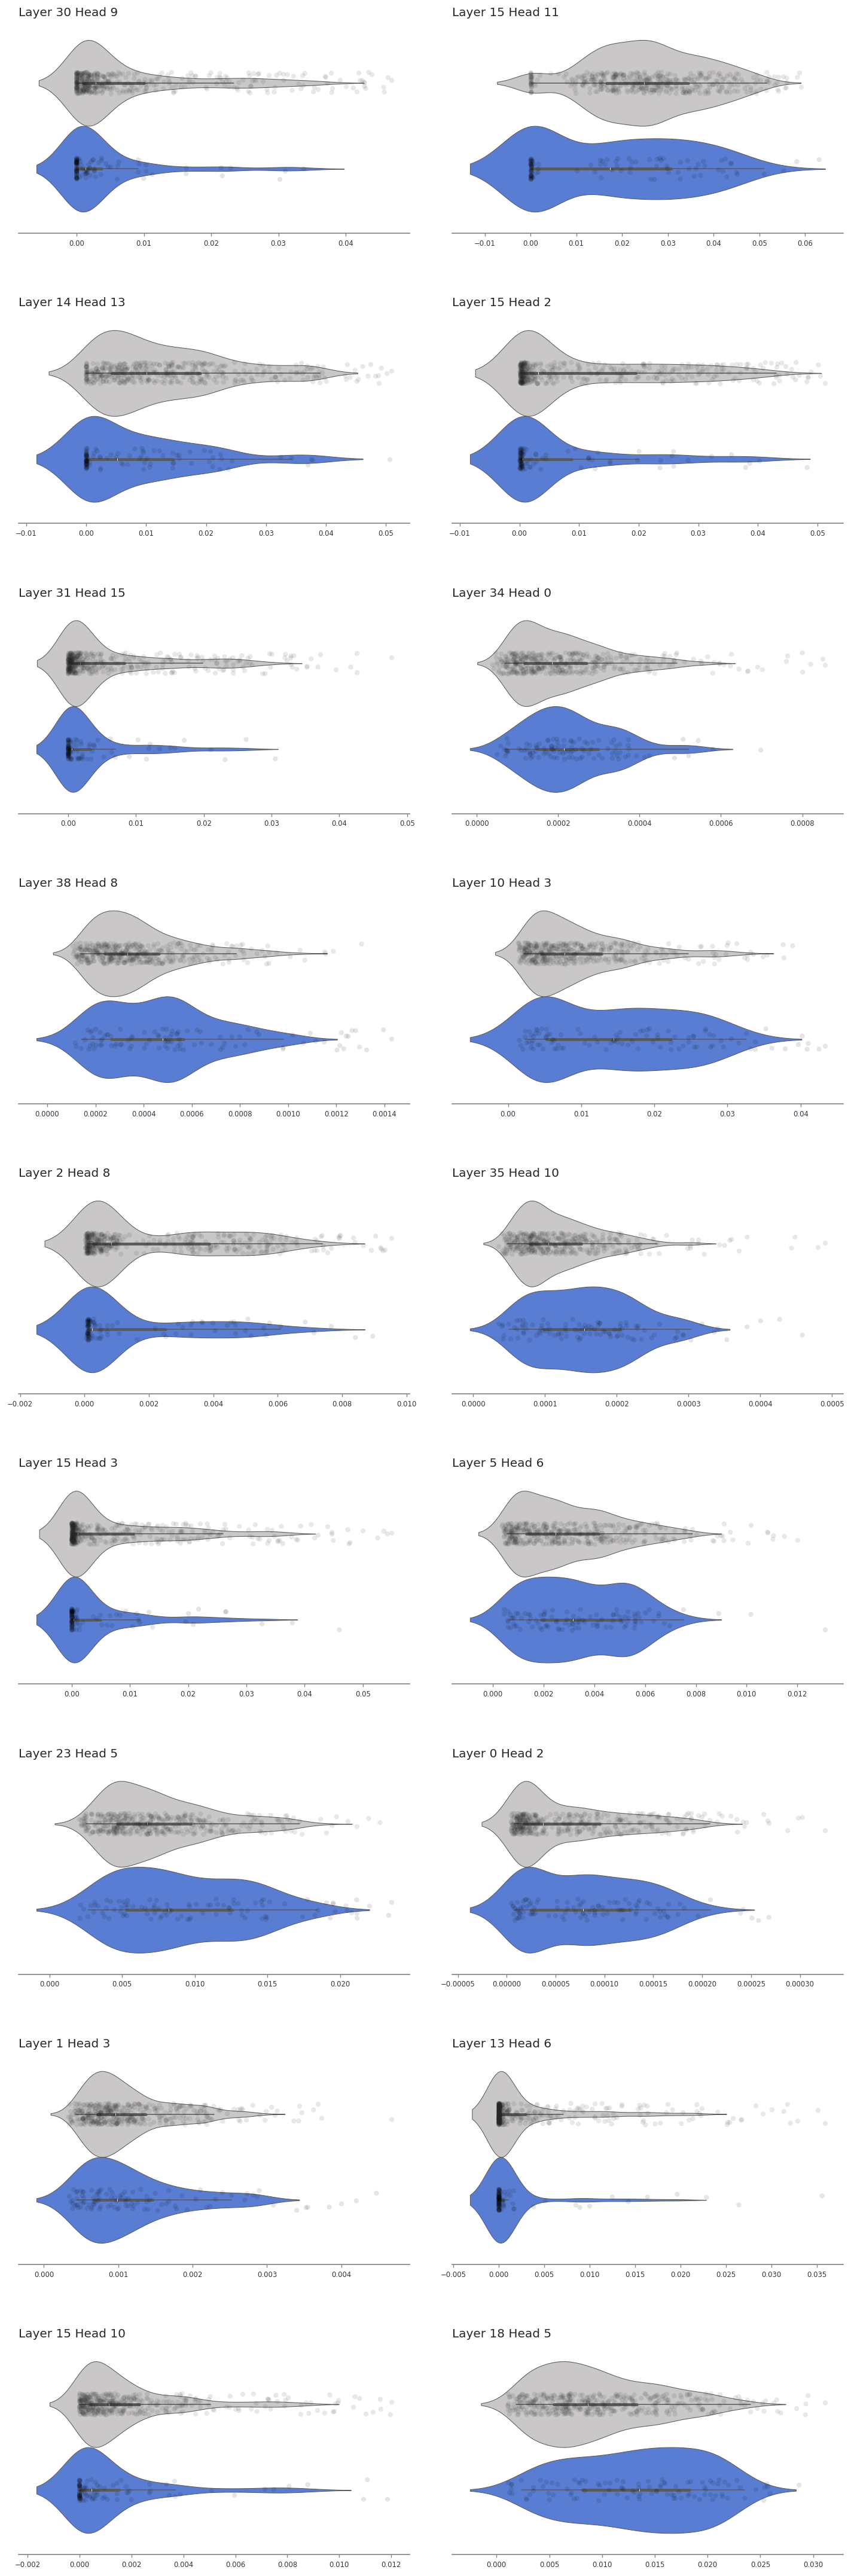

In [119]:
viz_numeric_data(
    query_df[list(common_features) + ['label', 'dataset']],
    list(common_features),
    'label',
    group_column=None,
    fig_cols=2,
    orient='h',
    title_func=lambda x: " ".join(x.split('_')).title()
)

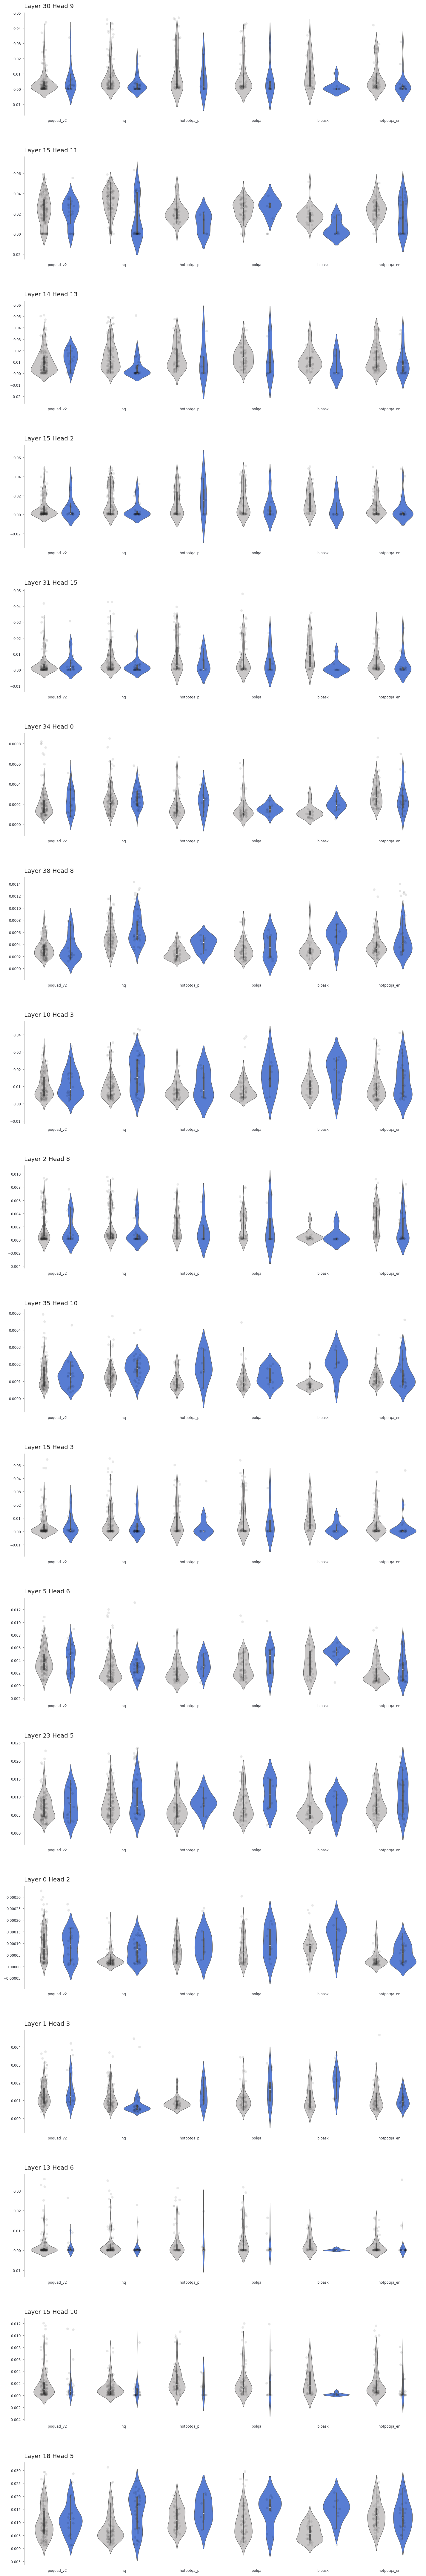

In [120]:
viz_numeric_data(
    query_df[list(common_features) + ['label', 'dataset']],
    list(common_features),
    'label',
    group_column='dataset',
    fig_cols=1,
    orient='v',
    title_func=lambda x: " ".join(x.split('_')).title(),
    title_pad=10,
)

In [127]:
validation_results = []

# Loop over each unique dataset
for dataset in query_df['dataset'].unique():

    in_dist_sample = query_df.loc[query_df['dataset'] != dataset]
    out_dist_sample = query_df.loc[query_df['dataset'] == dataset]

    stats_grouped = in_dist_sample.drop(columns=['dataset']).groupby('label').agg(['median']).T
    stats_grouped['median_proportion'] = stats_grouped[0] / stats_grouped[1]
    stats_grouped = stats_grouped.reset_index().rename(columns={'level_0': 'feature', 'level_1': 'statistic'})

    # print(stats_grouped)

    train_columns = stats_grouped.sort_values('median_proportion', ascending=False).head(TOP_N_FEATURES)['feature'].values.tolist() \
        + stats_grouped.sort_values('median_proportion', ascending=True).head(TOP_N_FEATURES)['feature'].values.tolist()

    print(f"Train columns: {train_columns}")

    X_train, X_val = in_dist_sample[train_columns], out_dist_sample[train_columns]
    y_train, y_val = in_dist_sample['label'], out_dist_sample['label']
    
    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    print(f"{X_train.shape = }, {X_val.shape = }")

    models = {
        'LogisticRegression': LogisticRegression(max_iter=10000, class_weight='balanced', random_state=42),
        'LGBMClassifier': LGBMClassifier(
            n_estimators=25,
            learning_rate=0.005,
            max_depth=5,
            num_leaves=7,
            class_weight='balanced',
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            n_jobs=-1,
            silent=True,
            verbose=-1
        )
    }

    for model_name, model in models.items():
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        train_auc = roc_auc_score(y_train, train_pred)
        print(f"Train AUC for {dataset} with {model_name}: {train_auc}")

        # Validate the model
        y_pred = model.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)
        auc = roc_auc_score(y_val, y_pred)

        # Store the result
        validation_results.append({
            'dataset': dataset,
            'model': model_name,
            'accuracy': accuracy,
            'auc': auc
        })

    print('\n\n')

Train columns: ['layer_30_head_9', 'layer_31_head_15', 'layer_15_head_3', 'layer_14_head_13', 'layer_13_head_6', 'layer_11_head_9', 'layer_15_head_11', 'layer_0_head_2', 'layer_10_head_3', 'layer_18_head_5', 'layer_21_head_4', 'layer_35_head_10', 'layer_38_head_8', 'layer_0_head_14']
X_train.shape = (388, 14), X_val.shape = (141, 14)
Train AUC for poquad_v2 with LogisticRegression: 0.7312462966620581
Train AUC for poquad_v2 with LGBMClassifier: 0.7963262887616038



Train columns: ['layer_13_head_6', 'layer_15_head_3', 'layer_31_head_15', 'layer_12_head_15', 'layer_15_head_2', 'layer_13_head_4', 'layer_15_head_10', 'layer_10_head_3', 'layer_35_head_10', 'layer_8_head_10', 'layer_38_head_8', 'layer_5_head_6', 'layer_21_head_4', 'layer_18_head_5']
X_train.shape = (387, 14), X_val.shape = (142, 14)
Train AUC for nq with LogisticRegression: 0.6848509707410446
Train AUC for nq with LGBMClassifier: 0.8022969647251845



Train columns: ['layer_13_head_6', 'layer_15_head_3', 'layer_15_head_2',

In [128]:
val_df = pd.DataFrame(validation_results)
val_df

dataset               model  accuracy       auc
0     poquad_v2  LogisticRegression  0.631206  0.547619
1     poquad_v2      LGBMClassifier  0.716312  0.519048
2            nq  LogisticRegression  0.556338  0.619092
3            nq      LGBMClassifier  0.718310  0.649666
4   hotpotqa_pl  LogisticRegression  0.830189  0.659938
5   hotpotqa_pl      LGBMClassifier  0.811321  0.709627
6         polqa  LogisticRegression  0.835821  0.670498
7         polqa      LGBMClassifier  0.880597  0.696360
8        bioask  LogisticRegression  0.945946  0.888889
9        bioask      LGBMClassifier  0.810811  0.648810
10  hotpotqa_en  LogisticRegression  0.719101  0.654809
11  hotpotqa_en      LGBMClassifier  0.764045  0.685112